##  Timing a Naive Modified Gram-Schmidt base QR decomposition

Well, I never set out to do this timing comparison, much less write a bare bones notebook about it, until I saw the huge differences between BLAS and naively coded Julia and wondered, how is that possible?

Since I hate to be dragged through the woods when reading a something technical, we will start with the punch line first: It's really tough to even come close to a BLAS QR when using a straightforward MGS based QR.  But, if you are going to try, perhaps Julia (or rather LLVM) is the way to go. First the results for a range of built in QR decompositions.  These results are all computed on the same Intel Skull Canyon NUC with 32GB of memory.  The Julia results are all generated using the @btime macro from **BenchmarkTools**, while the Matlab results were generated with the tic, tok, commands for a single run (and should therefore have more variability)

In [10]:
using BenchmarkTools
using PyPlot

In [2]:
# QR timing for built in QR
#  Matlab 2015a
#  Julia 1.4
#    OpenBLAS
#    MKL 
#          size  Matlab   Julia OB   Julia MKL   Julia MKL 1 thread 
timing = [ 1000   0.198    0.041     0.016          0.035
           2000   0.473    0.214     0.122          0.271
           3000   1.108    0.652     0.435          1.095
           4000   2.419    1.804     0.984          2.316
           5000   4.421    2.807     1.908          5.238
           6000   7.614    4.658     3.413          8.894
           7000  10.899    7.665     6.448         13.731
           8000  15.585   11.751     8.375         19.247
           9000  22.513   16.155    12.277         31.070
          10000  30.016   23.206    18.245         40.575
          20000 251.131  208.654   135.570        326.281 ];

Now the timings for hand rolled MGS based QR.

In [ ]:
# QR timing for naive mgs implementation in Julia and Fortran
#                     mgs_qr   ns_mgs_qr   Fortran nb_mgs_qr
mgs_timing = [ 1000    2.511     1.406     3.668
               2000   16.942    13.161    26.893
               3000   54.831    45.687    91.483
               4000  130.366    99.034   220.041
               5000  252.853   208.034   427.793
               6000  456.295   360.883   837.098  ];

These are pretty pitiful.  The eye opener for me is just how much better BLAS is than tossed off code.  The difference from the best, Julia with MKL, and the best naively coded (in Julia) nb_mgs_qr, varies between 40X to 50X... **>40X!** (using a single thread)

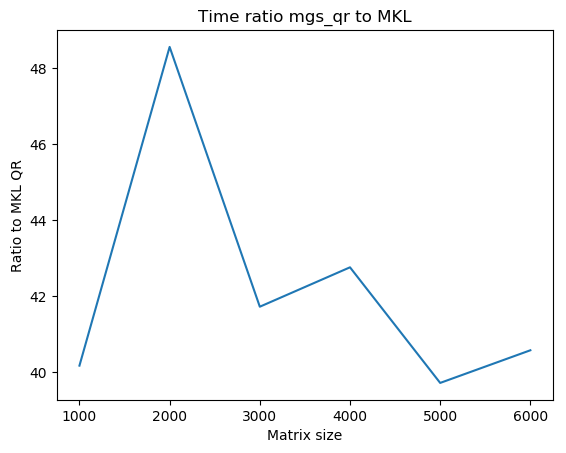

In [27]:
x = mgs_timing[:, 1]
y = mgs_timing[:, 3] ./ timing[1:6, 5]
plot(x, y)
xlabel("Matrix size")
ylabel("Ratio to MKL QR")
title("Time ratio mgs_qr to MKL");

Second thing to do is a gut check, are all the computational complexities correct? (They should all be M^3 because we are using square matricies)

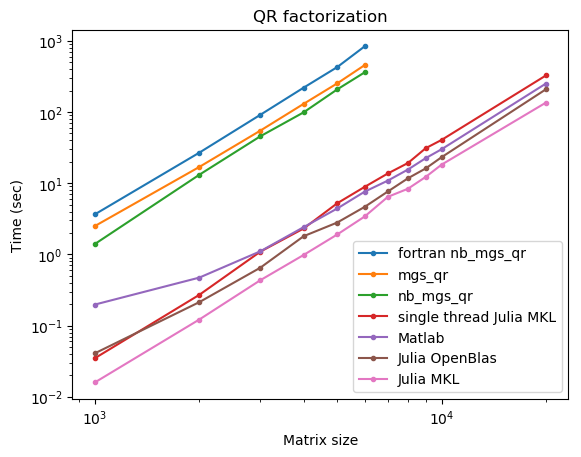

In [9]:
loglog(mgs_timing[:, 1], mgs_timing[:, 4], ".-", label="fortran nb_mgs_qr")
loglog(mgs_timing[:, 1], mgs_timing[:, 2], ".-", label="mgs_qr")
loglog(mgs_timing[:, 1], mgs_timing[:, 3], ".-", label="ns_mgs_qr")

loglog(timing[:,1], timing[:,5], ".-", label="single thread Julia MKL")
loglog(timing[:,1], timing[:,2], ".-", label="Matlab")
loglog(timing[:,1], timing[:,3], ".-", label="Julia OpenBlas")
loglog(timing[:,1], timing[:,4], ".-", label="Julia MKL")

legend()
xlabel("Matrix size")
ylabel("Time (sec)")
title("QR factorization");

OK, that looks all good (slope of 3 in loglog space).  I never really looked before, so I guess I should not be surprised, but the constant factors are just killers here. Now, here is the code.  First up is the modified Gram Schmidt in (hopefully) idiomatic Julia.

In [15]:
# using RHS slicing
function mgs_qr(a::Array{T, 2}) where T
    m, n = size(a)
    v = copy(a)
    r = zeros(T, n, n)
    q = Array{T}(undef, m, n)
    @inbounds @views for k = 1:n
        r[k, k] = norm(a[:, k])
        q[:, k] = v[:, k] / r[k, k]
        for j = k+1:n
            r[k, j] = q[:, k]' * v[:, j]
            v[:, j] = v[:, j] - r[k, j] * q[:, k]
        end
    end
    return q, r
end;

Pretty much a straight copy of Algorithm 5.2.6 from Golub and Van Loan (p. 255).  We have added two Julia specific annotations here.  First is the @inbounds to turn off bounds checking.  The second is to use a *view* of an array slice.  The reason is here is that by default, Julia makes copys of array slices that appear on RHS of assignments to avoid aliasing surprises. Let's time this on a 1000x1000 random array. (We make it diagonally dominant to try to avoid stability issues)

In [14]:
a = rand(1000, 1000) + I;
@btime mgs_qr(a);

  2.899 s (8001007 allocations: 7.79 GiB)


And we see here that there is still a ton of memory allocation going on.  I had initially thought that the **@views** would take care of that... perhaps I don't know what I am doing here (always a possibility).  We do have tools in Julia to look at this and can use the --track-allocation=user flag (see manual for more details) on the Julia executable.  Here are the results:

Yeah, right, not so good on the allocation front.  OK, so let's remove all the slicing on the RHS and write a non-slicing version of mgs_qr

In [19]:
function ns_mgs_qr(a::Array{T, 2}) where T
    m, n = size(a)
    v = copy(a)
    r = zeros(T, n, n)
    q = Array{T}(undef, m, n)
    @inbounds begin
        for k = 1:n
            r[k, k] = norm(view(a, :, k))
            for l = 1:m
                q[l, k] = v[l, k] / r[k, k]
            end
            for j = k+1:n
                qvdot = 0.0
                for l = 1:m
                    qvdot = qvdot + q[l, k] * v[l, j]
                end
                r[k, j] = qvdot
                for l = 1:m
                    v[l, j] = v[l, j] - r[k, j] * q[l, k]
                end
            end
        end
    end
    return q, r
end;

And first checking the run time

In [20]:
@btime ns_mgs_qr(a);

  886.354 ms (1007 allocations: 22.93 MiB)


So goal accomplished on the allocations and the runtime.  Just to be certain, here are the detailed allocation results.

Here is what we gained by rewriting the Julia code.

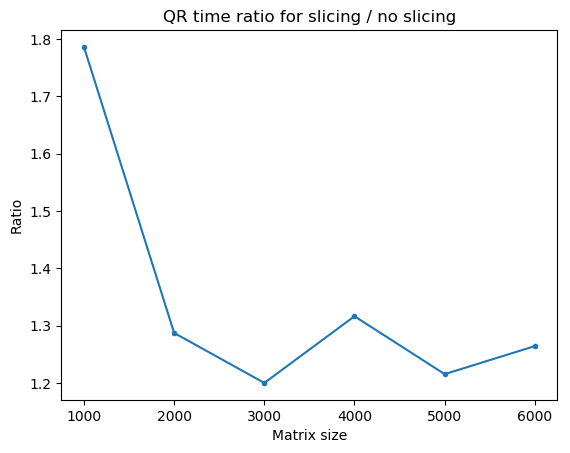

In [25]:
x = mgs_timing[:, 1]
y = mgs_timing[:, 2] ./ mgs_timing[:, 3]
plot(x, y, ".-")
xlabel("Matrix size")
ylabel("Ratio")
title("QR time ratio for slicing / no slicing");

So maybe in the large matrix limit you'd say a 20% to 30% slow down when using a coding style that induces allocations?  So really not something to worry about most of the time. (Should look in more detail at smaller matrix sizes)

But since this is still that this is ~40X slower than MKL BLAS. I am still left with the question, is that all me or is Julia adding to that slowdown?  One way to check it to code it up in another language and see.  If you read the results table at the beginning, you already know the answer. A direct translation of the no slicing code to Fortran (and using gfortran on Ubuntu 18.04) results in a slow down! (Fortran code later)

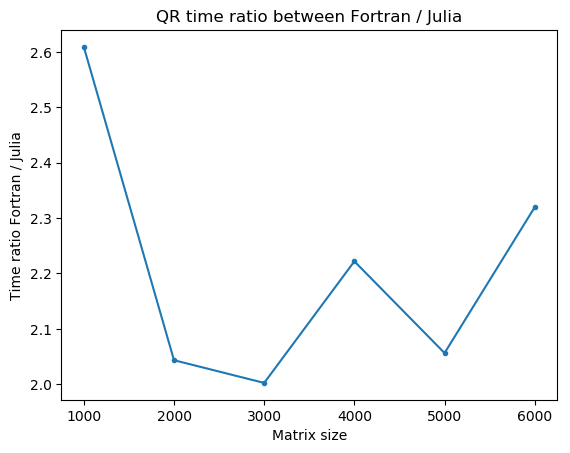

In [22]:
x = mgs_timing[:, 1]
y = mgs_timing[:, 4] ./ mgs_timing[:,3]
plot(x, y, ".-")
xlabel("Matrix size")
ylabel("Time ratio Fortran / Julia")
title("QR time ratio between Fortran / Julia");

So on this example, and used in this (maybe uninformed) way, Julia is 2X faster than Fortran.  Ok, Ok, really what's to be said is that LLVM is 2X faster than gfortran.  It does answer the question thought that, yeah, it's me, I am the slow coder here.

Just to beat this dead horse one more time here are the C++ using results using the Eigen header only code.  I've used this in the past and found it very convenient, but I did no performance testing with it.

In [23]:
timing_eigen = [1000     8.944
                2000    73.364
                3000   247.770
                4000   523.065
                5000  1114.259 
                6000  1979.142 ];

Ooops! This is the worst of the lot so far.

Here is the code for the C++ / Eigen version

And here is the Fortran code